In [ ]:
import os
import datetime
import pytz

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy.signal import find_peaks

In [35]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'

In [2]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False
all_cols = ['Grid Feed In', 'External Energy Supply', 'Internal Power Supply', 'Current Power', 'Self Consumption', 'Ambient Temperature', 'Module Temperature', 'Total Irradiation']

In [40]:
csv_path = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/export_device_3_basic_aggregated_15minutes.csv')
csv_path

6335080/6335080 [==============================] - 0s 0us/step


'C:\\Users\\ASUS\\.keras\\datasets\\export_device_3_basic_aggregated_15minutes.csv'

In [41]:
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)

row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 71351


,Device ID,Start Time,End Time,Record Count,Grid Feed In,External Energy Supply,Internal Power Supply,Current Power,Self Consumption,Ambient Temperature,Module Temperature,Total Irradiation
0,3,2021-11-08 06:00:00,2021-11-08 06:15:00,120,0.0,4496.8,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,3,2021-11-08 06:15:00,2021-11-08 06:30:00,120,0.0,4268.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,3,2021-11-08 06:30:00,2021-11-08 06:45:00,120,0.0,3307.4,885.566667,885.566667,885.566667,0.0,0.0,0.0
3,3,2021-11-08 06:45:00,2021-11-08 07:00:00,120,314.7,1090.1,3026.966667,3341.666667,3026.966667,0.0,0.0,0.0
4,3,2021-11-08 07:00:00,2021-11-08 07:15:00,120,2727.7,0.0,3223.850000,5930.741667,3223.850000,NaN,NaN,NaN


In [42]:
if df.get('Datetime') is not None:
    # Ensure timestamp column is datetime type
    if df.index.dtype != 'datetime64[ns]':
        df.index = pd.to_datetime(df['Datetime'])
        df.pop('Datetime')
        
    print(df.index.year.unique())
    print(df.index.year.value_counts())

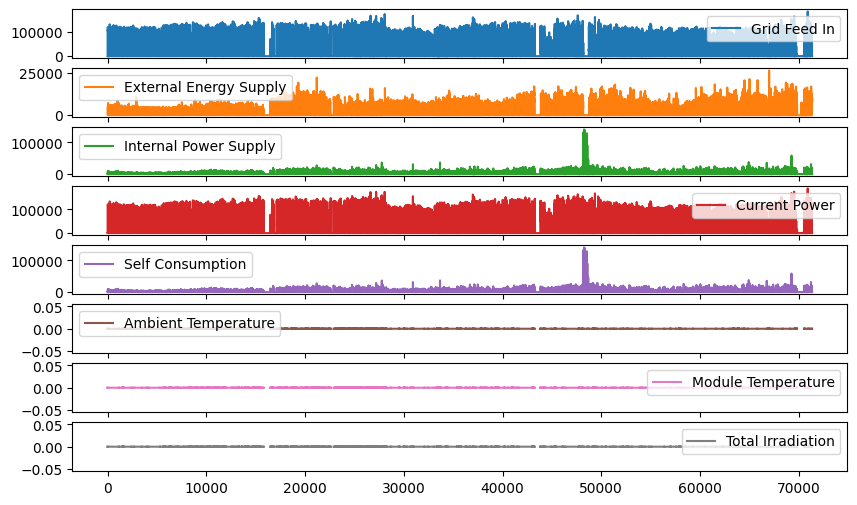

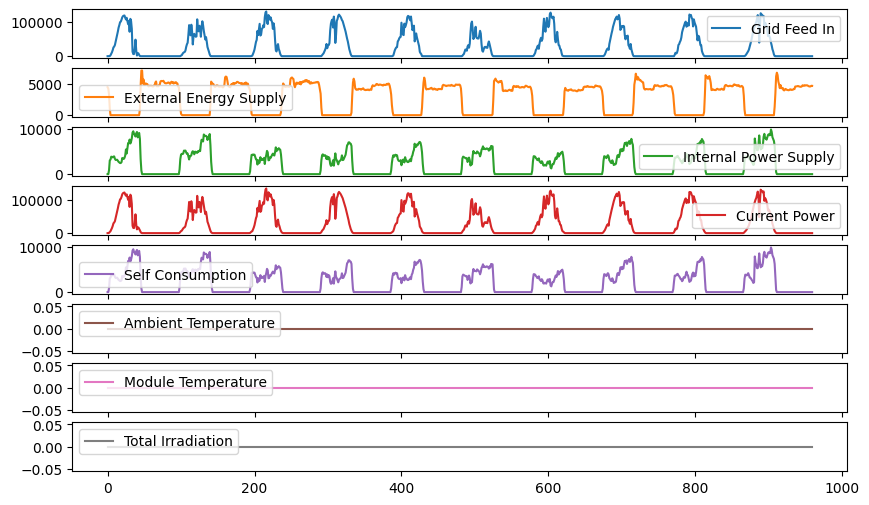

In [43]:
plot_cols = all_cols
plot_features = df[plot_cols]
plot_features.index = df.index
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:960]
plot_features.index = df.index[:960]
_ = plot_features.plot(subplots=True)

In [7]:
# List of columns to check for zeros
zero_columns = [col for col in all_cols]

# Check which columns actually exist in the dataframe
valid_columns = [col for col in zero_columns if col in df.columns]
if len(valid_columns) != len(zero_columns):
    missing = set(zero_columns) - set(valid_columns)
    print(f"Warning: Some columns not found: {missing}")

mask_zeros = df[valid_columns].eq(0).all(axis=1)
zero_rows = df[mask_zeros].copy()
zero_rows

,Grid Feed In,External Energy Supply,Internal Power Supply,Current Power,Self Consumption,Ambient Temperature,Module Temperature,Total Irradiation,is_weekend
Datetime,,,,,,,,,
2021-12-04 21:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True
2022-08-26 15:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2022-08-26 15:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2022-08-26 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2022-08-26 16:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...
2024-08-26 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2024-08-26 21:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2024-08-26 21:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


Text(0, 0.5, 'Current Power')

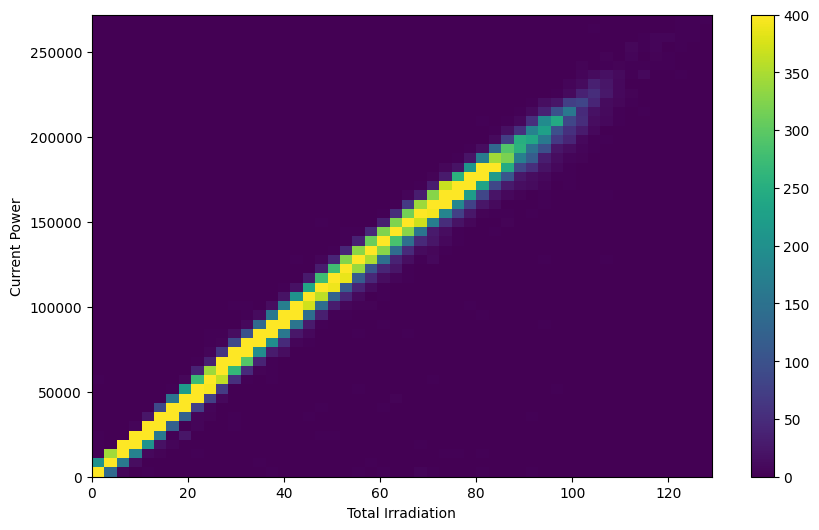

In [8]:
plt.hist2d(df['Total Irradiation'], df['Current Power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Total Irradiation')
plt.ylabel('Current Power')

Text(0, 0.5, 'Current Power')

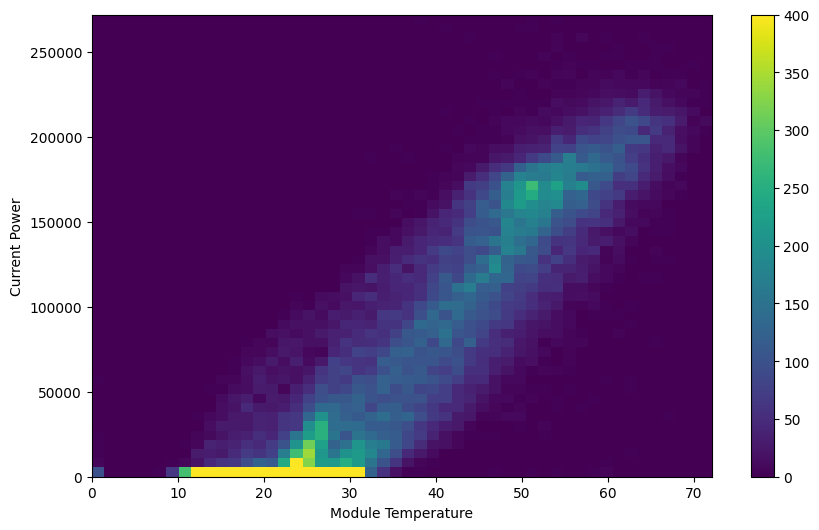

In [9]:
plt.hist2d(df['Module Temperature'], df['Current Power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Module Temperature')
plt.ylabel('Current Power')

Text(0, 0.5, 'Self Consumption')

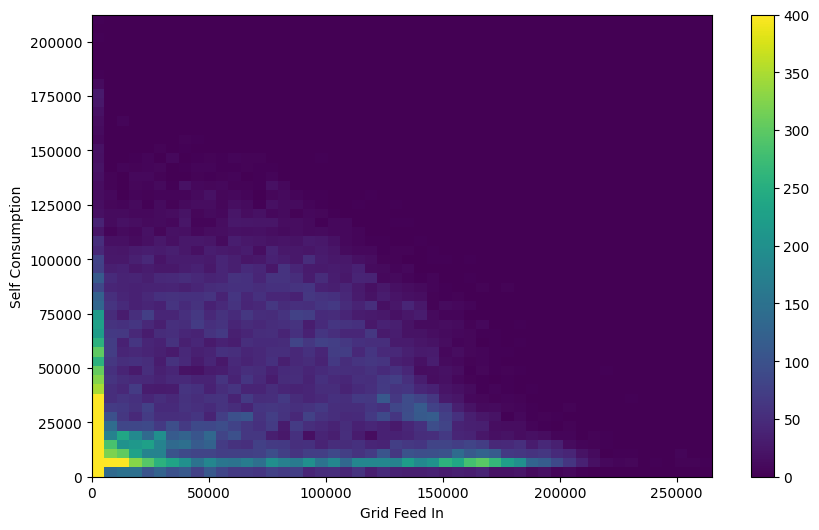

In [10]:
plt.hist2d(df['Grid Feed In'], df['Self Consumption'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Grid Feed In')
plt.ylabel('Self Consumption')

In [11]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
timestamp_s

Float64Index([1636196400.0, 1636197300.0, 1636198200.0, 1636199100.0,
              1636200000.0, 1636200900.0, 1636201800.0, 1636202700.0,
              1636203600.0, 1636204500.0,
              ...
              1749170700.0, 1749171600.0, 1749172500.0, 1749173400.0,
              1749174300.0, 1749175200.0, 1749176100.0, 1749177000.0,
              1749177900.0, 1749178800.0],
             dtype='float64', name='Datetime', length=125537)

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Grid Feed In,125537.0,29901.060392,49617.196018,0.0,0.000,0.000000,47042.644628,265040.000
External Energy Supply,125537.0,5376.518394,8458.119648,0.0,0.000,3620.000000,6785.000000,107827.000
Internal Power Supply,125537.0,17705.744080,29310.804030,0.0,0.000,117.116667,23236.666667,212427.000
Current Power,125537.0,47565.971196,66245.069457,0.0,0.000,141.350000,93204.158333,271857.000
Self Consumption,125537.0,17705.744080,29310.804030,0.0,0.000,117.116667,23236.666667,212427.000
Ambient Temperature,125537.0,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.000
Module Temperature,125537.0,31.341748,13.338672,0.0,22.325,25.460000,41.250000,72.125
Total Irradiation,125537.0,21.338169,29.991251,0.0,0.000,0.255556,40.577778,129.100


In [13]:
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Total data points 125537
Total data points in a day 96.0


Text(0.5, 1.0, 'Time of day signal')

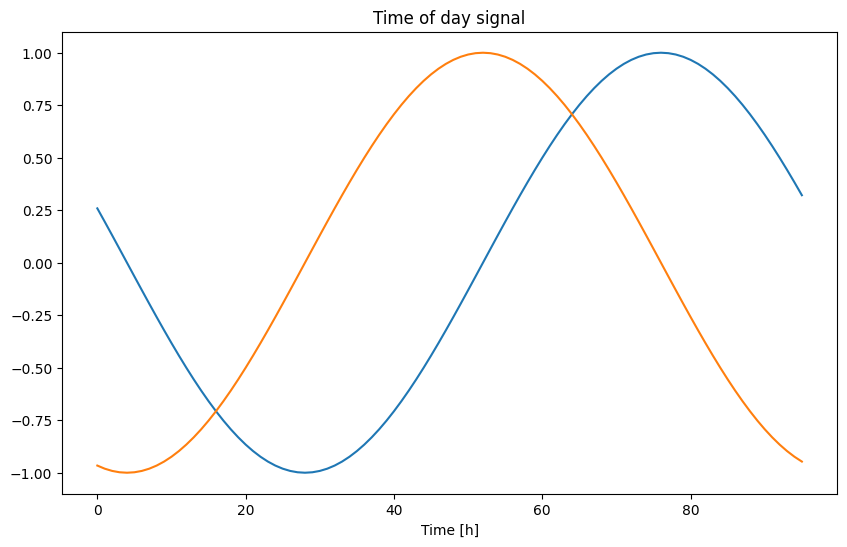

In [14]:
print(f"Total data points {len(df)}")
print(f"Total data points in a day {24*60/15}")

plt.plot(np.array(df['Day sin'])[:96])
plt.plot(np.array(df['Day cos'])[:96])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [15]:
def manual_rfftfreq(n_samples, d):
    """
    Manual implementation of np.fft.rfftfreq()
    
    Parameters:
    n_samples (int): Number of samples in the original time domain signal
    d (float): Sample spacing (time between samples) in seconds
    
    Returns:
    numpy array: Array of frequencies corresponding to FFT output
    """
    # Calculate the sample rate (samples per second)
    sample_rate = 1.0 / d
    
    # For real FFT, we get n//2 + 1 frequency bins (including DC component)
    num_freq_bins = n_samples // 2 + 1
    
    # Calculate frequency increment between bins
    freq_increment = sample_rate / n_samples
    
    # Generate frequencies from 0 to Nyquist frequency
    frequencies = np.arange(num_freq_bins) * freq_increment
    
    return frequencies

# Example usage:
n_samples = len(df['Current Power'])
sample_period = 15 * 60  # 15 minutes in seconds

# Manual calculation
manual_frequencies = manual_rfftfreq(n_samples, sample_period)
manual_frequencies[-1]

0.0005555511301227704

In [16]:
# Verify against NumPy's implementation
numpy_frequencies = np.fft.rfftfreq(n_samples, d=sample_period)

# Compare the first few values
print("Manual calculation:", manual_frequencies[:5])
print("NumPy calculation :", numpy_frequencies[:5])

Manual calculation: [0.00000000e+00 8.85086557e-09 1.77017311e-08 2.65525967e-08
 3.54034623e-08]
NumPy calculation : [0.00000000e+00 8.85086557e-09 1.77017311e-08 2.65525967e-08
 3.54034623e-08]


In [17]:
# Find peaks manually
def find_peaks_manual(x, min_prominence_ratio=0.01):
    peaks = []
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] and x[i] > x[i+1]:
            peaks.append(i)

    print(peaks)
    
    max_val = x.max()
    threshold = max_val * min_prominence_ratio
    peaks = [p for p in peaks if x[p] > threshold]
    
    return np.array(peaks)

In [18]:
fft = tf.signal.rfft(df['Current Power'])
max_val = np.abs(fft).max()
f_per_dataset = np.arange(0, len(fft))
years_per_dataset = n_samples/(sample_period)

f_per_year = f_per_dataset/years_per_dataset

In [19]:
# Get amplitude spectrum
amplitude_spectrum = np.abs(fft.numpy())  # Convert to NumPy array

# Find the peaks
peaks = find_peaks_manual(amplitude_spectrum)
# Convert peak indices to frequencies
peak_frequencies = f_per_year[peaks]

[4, 8, 11, 13, 16, 19, 22, 26, 29, 32, 36, 39, 43, 47, 51, 57, 60, 62, 64, 69, 71, 75, 78, 85, 90, 93, 96, 99, 101, 103, 107, 111, 115, 118, 121, 123, 126, 129, 133, 135, 137, 139, 145, 147, 151, 153, 158, 161, 165, 168, 172, 180, 182, 185, 187, 189, 193, 197, 200, 204, 208, 210, 216, 218, 221, 224, 226, 229, 233, 236, 238, 240, 243, 247, 250, 252, 254, 257, 260, 265, 268, 271, 274, 277, 279, 282, 285, 289, 291, 293, 295, 297, 300, 304, 306, 309, 311, 314, 317, 320, 323, 325, 327, 329, 331, 333, 335, 338, 340, 343, 347, 351, 354, 357, 362, 368, 372, 376, 379, 383, 386, 389, 392, 396, 399, 403, 405, 411, 415, 417, 420, 422, 424, 426, 429, 431, 435, 437, 440, 444, 447, 451, 454, 456, 460, 463, 468, 471, 475, 480, 484, 489, 495, 497, 500, 502, 505, 508, 510, 512, 519, 521, 525, 528, 531, 533, 536, 542, 544, 546, 551, 554, 558, 561, 563, 567, 569, 571, 573, 576, 580, 583, 586, 589, 592, 595, 598, 601, 607, 610, 612, 616, 619, 622, 628, 632, 634, 638, 641, 643, 646, 648, 650, 653, 656, 658,

In [20]:
# Convert frequencies to periods
peak_periods = 1 / peak_frequencies

# Sort peaks by amplitude
sorted_indices = np.argsort(-amplitude_spectrum[peaks])
peaks = peaks[sorted_indices]
peak_frequencies = peak_frequencies[sorted_indices]
peak_periods = peak_periods[sorted_indices]

# Show results (top 5 peaks)
for i, (freq, period) in enumerate(zip(peak_frequencies[:5], peak_periods[:5])):
    print(f"Peak {i+1}: Frequency = {freq:.4f} cycles/year")
    
    # Convert to more intuitive units
    days = period * 365.25
    if days < 1:
        print(f"    Period ≈ {days*24:.2f} hours")
    elif days < 30:
        print(f"    Period ≈ {days:.2f} days")
    else:
        print(f"    Period ≈ {period*12:.2f} months")

Peak 1: Frequency = 9.3773 cycles/year
    Period ≈ 1.28 months
Peak 2: Frequency = 18.7475 cycles/year
    Period ≈ 19.48 days
Peak 3: Frequency = 28.1248 cycles/year
    Period ≈ 12.99 days
Peak 4: Frequency = 18.7761 cycles/year
    Period ≈ 19.45 days
Peak 5: Frequency = 18.7260 cycles/year
    Period ≈ 19.51 days


Text(0.5, 1.0, 'Frequency Spectrum of Current Power with Peak Frequencies')

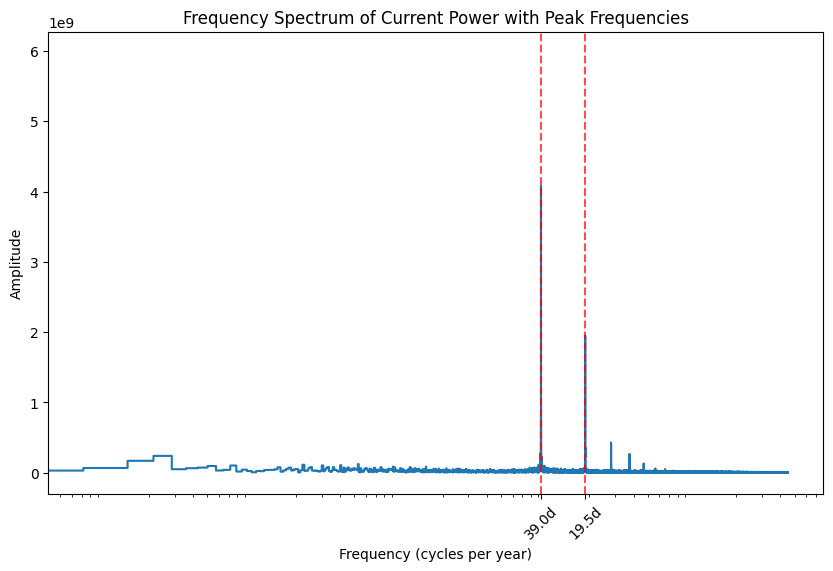

In [21]:
# Get top peaks (assuming you've already calculated them)
top_peaks = peak_frequencies[:2]  # Top 3 peaks

# Create frequency ticks including standard references and top peaks
#tick_locations = [1, 12, 52, 365.2524]  # Standard references (year, month, week, day)
tick_locations = []
tick_locations.extend(top_peaks)  # Add peak frequencies
tick_locations.sort()  # Sort them in ascending order

# Create corresponding labels
tick_labels = []
for freq in tick_locations:
    if abs(freq - 1) < 0.1:
        tick_labels.append('1/Year')
    elif abs(freq - 12) < 0.5:
        tick_labels.append('1/Month')
    elif abs(freq - 52) < 2:
        tick_labels.append('1/Week')
    elif abs(freq - 365.2524) < 10:
        tick_labels.append('1/Day')
    else:
        period_days = (1/freq) * 365.2524
        if period_days < 1:
            tick_labels.append(f'{period_days*24:.1f}h')
        else:
            tick_labels.append(f'{period_days:.1f}d')

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')

# Apply the customized ticks to your plot
plt.xticks(tick_locations, labels=tick_labels, rotation=45)

# Add a vertical line at each peak for emphasis
for freq in top_peaks:
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Current Power with Peak Frequencies')

In [22]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [23]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

[Text(0, 0, 'Grid Feed In'),
 Text(1, 0, 'External Energy Supply'),
 Text(2, 0, 'Internal Power Supply'),
 Text(3, 0, 'Current Power'),
 Text(4, 0, 'Self Consumption'),
 Text(5, 0, 'Ambient Temperature'),
 Text(6, 0, 'Module Temperature'),
 Text(7, 0, 'Total Irradiation'),
 Text(8, 0, 'is_weekend'),
 Text(9, 0, 'Day sin'),
 Text(10, 0, 'Day cos'),
 Text(11, 0, 'Year sin'),
 Text(12, 0, 'Year cos')]

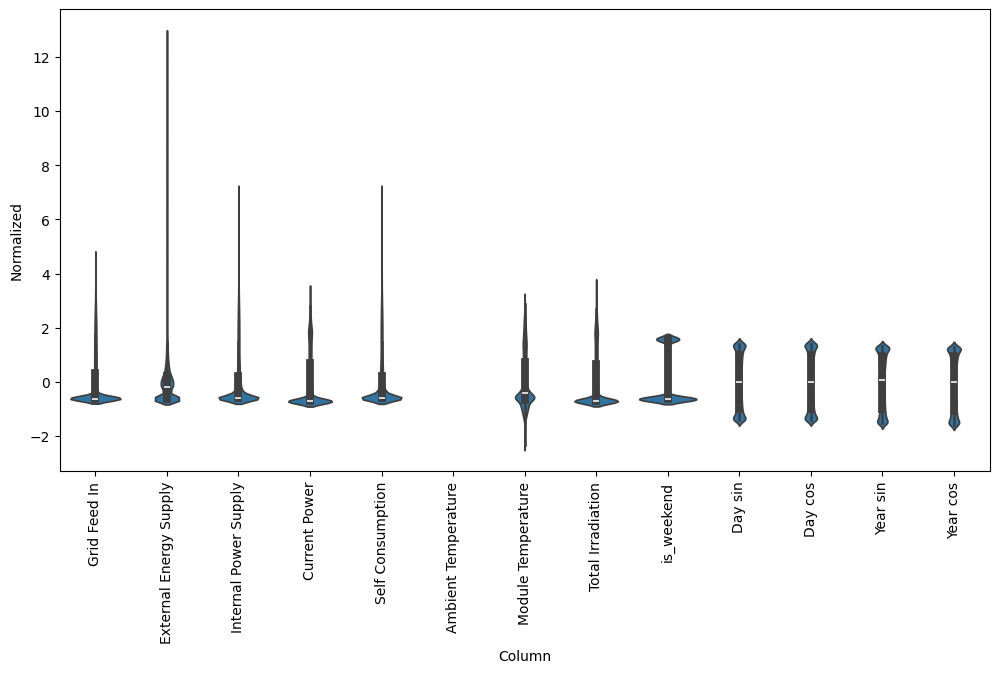

In [24]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(range(len(df.keys())))
ax.set_xticklabels(df.keys(), rotation=90)

In [25]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Current Power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [15min]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [26]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Current Power'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Current Power']

In [27]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Current Power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Current Power']

In [28]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [29]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


In [30]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [31]:
val_performance = {}
performance = {}

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
2747/2747 [==============================] - 3s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
785/785 [==============================] - 1s 620us/step - loss: nan - mean_absolute_error: nan


In [32]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


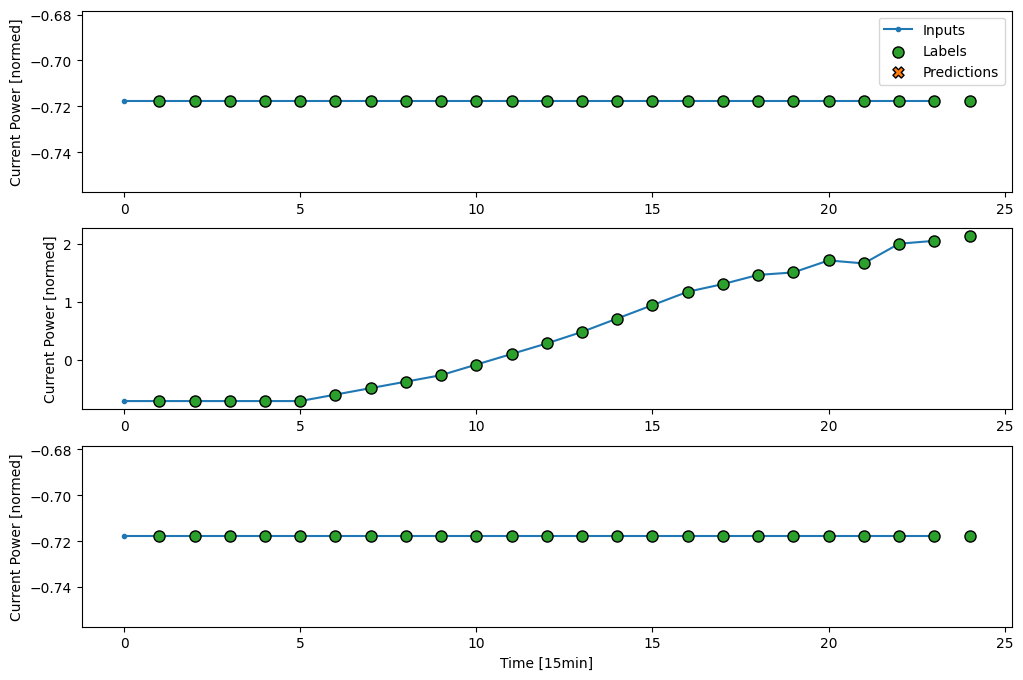

In [33]:
wide_window.plot(linear)

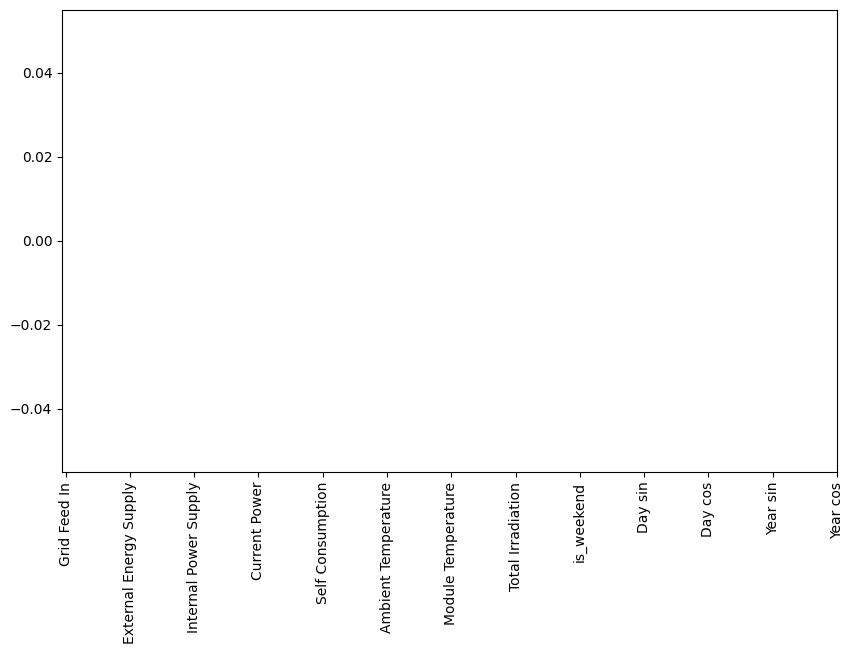

In [34]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
2747/2747 [==============================] - 4s 1ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
785/785 [==============================] - 1s 1ms/step - loss: nan - mean_absolute_error: nan


In [36]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Current Power'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Current Power']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

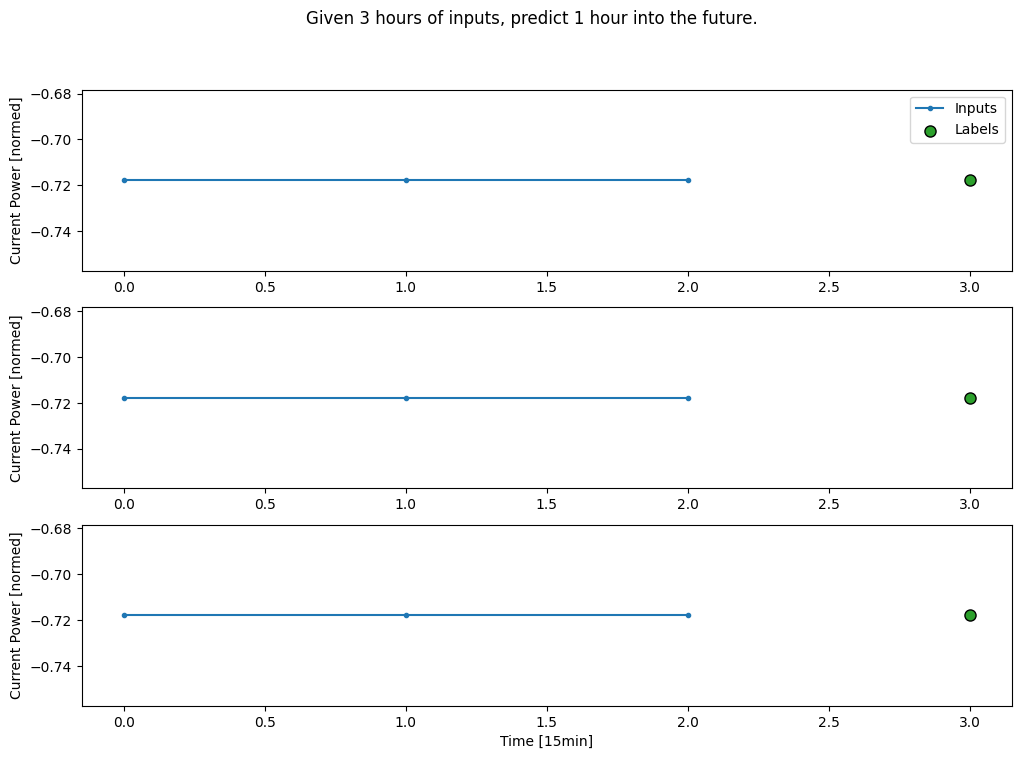

In [37]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [38]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [39]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [40]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

785/785 [==============================] - 1s 1ms/step - loss: 0.9809 - mean_absolute_error: 0.8438


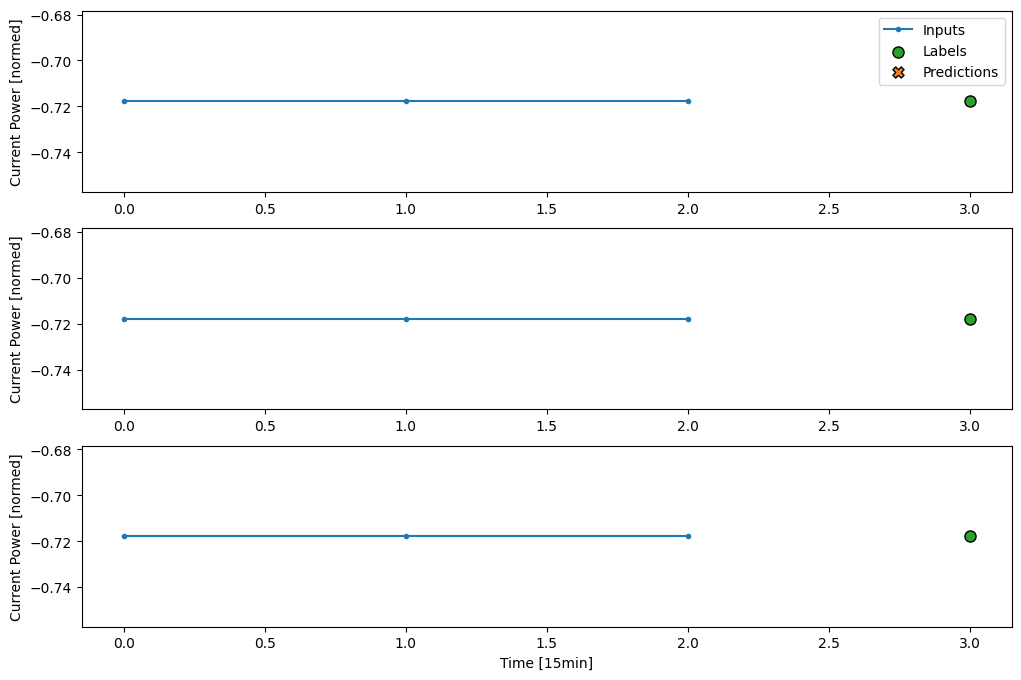

In [41]:
conv_window.plot(multi_step_dense)

In [42]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [43]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [44]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

785/785 [==============================] - 1s 1ms/step - loss: nan - mean_absolute_error: nan


In [45]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [46]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Current Power'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Current Power']

In [47]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


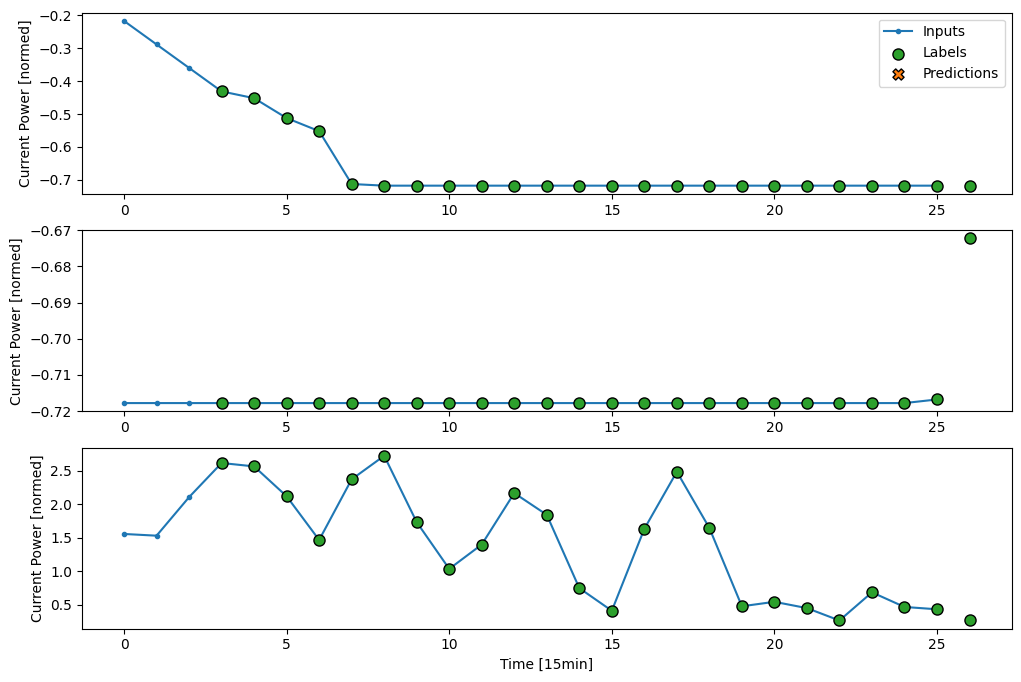

In [48]:
wide_conv_window.plot(conv_model)

In [49]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [50]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


In [51]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
2746/2746 [==============================] - 25s 8ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
2746/2746 [==============================] - 23s 8ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan


In [52]:
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

784/784 [==============================] - 3s 3ms/step - loss: nan - mean_absolute_error: nan


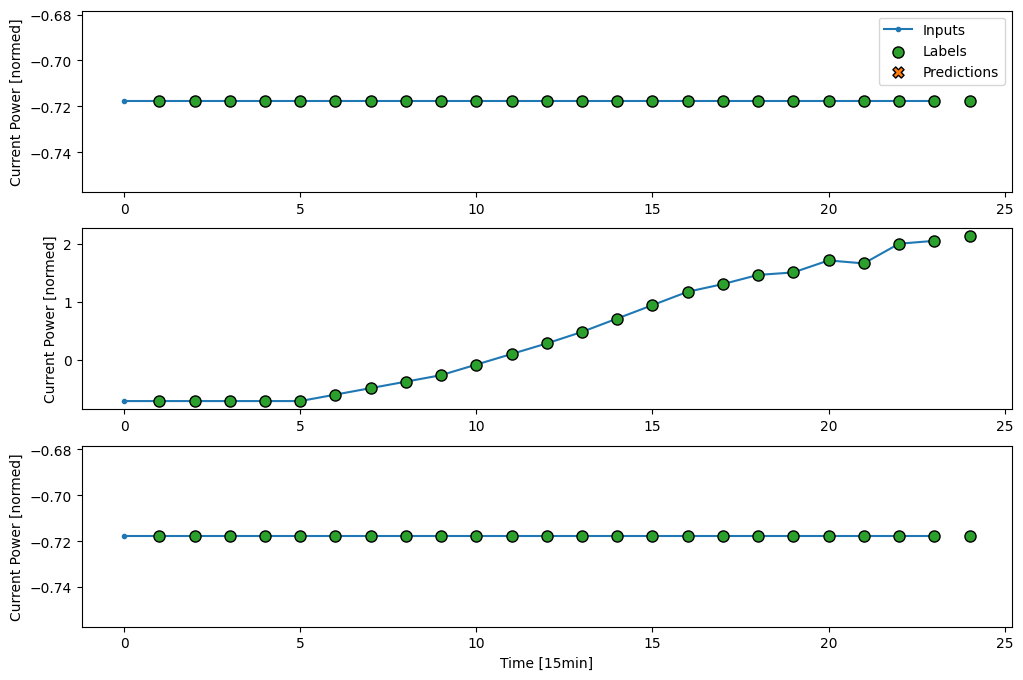

In [53]:
wide_window.plot(lstm_model)

In [54]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [55]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

784/784 [==============================] - 3s 3ms/step - loss: nan - mean_absolute_error: nan

CPU times: total: 12min 30s
Wall time: 55 s


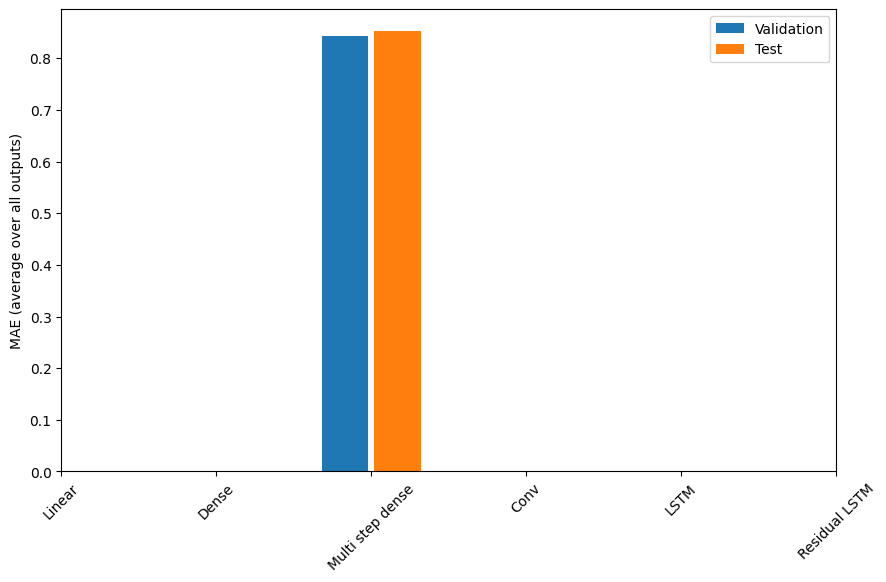

In [56]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()